# Preparation

In [1]:
import numpy as np
from astropy.time import Time
from astroquery.simbad import Simbad
from astroquery.ipac.ned import Ned
from astroplan import Observer
from astroplan.exceptions import TargetAlwaysUpWarning
from astropy.coordinates import Angle, EarthLocation, AltAz, SkyCoord
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
from matplotlib.ticker import FixedLocator
from matplotlib.lines import Line2D
# import datetime
from datetime import datetime, timedelta
from scipy.interpolate import griddata
import pytz
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import inspect
import warnings

# Helper Functions

In [2]:
def dms_to_deg(d: float, m: float, s: float) -> float:
    """ This function takes coordinates in the format of degree:minute:second and calculates into decimal degrees.
    
    Parameters
    ----------
    d : float
        Degrees
    m : float
        Minutes
    s : float
        Seconds
    
    Returns
    -------
    float
        d:m:s in decimal degrees"""
    if d == 0:
        degrees =(np.abs(d) + m/60 + s/3600)
    else:
        degrees = (np.abs(d) + m/60 + s/3600)* np.sign(d)
    return degrees

def deg_to_dms(degrees: float) -> tuple[int, int, float]:
    """ This function takes coordinates in the format of decimal degrees and calculates into degree:minute:second.
    
    Parameters
    ----------
    degrees : float
        Angle in degrees
    
    Returns
    -------
    tuple[int, int, float]
        Degrees, minutes, seconds
    """
    deg=np.abs(degrees)
    d=np.round(np.floor(deg)*degrees/deg,0)
    m=np.round(np.floor(((deg-np.abs(d))*60)),0)
    s=np.round(((deg-np.abs(d)-(m/60))*3600),2)
    return d,m,s

def hms_to_deg(h: float, m: float, s: float) -> float:
    """ This function takes coordinates in the format of hours:minute:second and calculates into decimal degrees.
    Parameters
    ----------
    h : float
        Hours
    m : float
        Minutes
    s : float
        Seconds

    Returns
    -------
    float
        h:m:s in decimal degrees
    """
    if h == 0:
        degrees = 15*(np.abs(h) + m/60 + s/3600)
    else:
        degrees = 15*(np.abs(h) + m/60 + s/3600)*np.sign(h)
    return degrees

def H_to_hms(H: float) -> tuple[int, int, float]:
    """ This function takes coordinates in the format of decimal hours and calculates into hours:minutes:seconds.
    
    Parameters
    ----------
    H : float
        Hours
        
    Returns
    -------
    tuple[int, int, float]
        Hours, minutes, seconds
    """
    h=np.floor(H)
    m=np.floor((H-h)*60)
    s=np.round((H-h-(m/60))*3600,2)
    return h,m,s

def deg_to_rad(degrees: float) -> float:
    """This function takes degrees and calculates into radians.
    
    Parameters
    ----------
    degrees : float
        Angle in degrees
    
    Returns
    -------
    float
        Angle in radians
    """
    rad = degrees * np.pi/180
    return rad

def rad_to_deg(rad: float) -> float:
    """This function takes radians and calculates into degrees.
    
    Parameters
    ----------
    rad : float
        Angle in radians

    Returns
    -------
    float
        Converted angle
    """
    degrees = rad * 180/np.pi
    return degrees


def Surface_Brightness(objects: np.ndarray) -> np.ndarray:
    """
    This function calculates the surface brightness of the object

    Parameters
    ----------
    objects : np.ndarray
        array of objects with data

    Returns
    -------
    np.ndarray
        array with surface brightness data
    """    
    results = []
    
    for n in range(len(objects)):
        try:
            magnitude = objects[n, 3]
            if magnitude == "--":
                results.append(None)
                continue
            
            major_axis, minor_axis = objects[n, 4], objects[n, 5]
            if major_axis == "--" or minor_axis == "--":
                results.append(None)
                continue
            
            # Calculate area
            Area = np.pi * (float(major_axis) / 2) * (float(minor_axis) / 2)

            # Compute Surface Brightness
            Surface_Brightness = float(magnitude) + 2.5 * np.log10(Area)
            results.append(Surface_Brightness)

        except (ValueError, TypeError,Exception) as e:
            print(f"Error processing row {n}: {e}")
            results.append(None)

    data_arr_Sb = np.column_stack((objects, results))

    return data_arr_Sb

# Az_Alt

In [3]:
def Az_Alt(zeit_jd: float, ra_deg: float, dec_deg: float, Lon: float = 10.88846, Lat: float = 49.88474) -> tuple[float, float]:
    """
    This function converts equatorial coordinates (RA,DEC) into horizontal coordinates (Alt,Az) for a given time.

    Parameters
    ----------
    zeit_jd : float
        Time in Julian date
    ra_deg : float
        Right ascension in degrees
    dec_deg : float
        Declination in degrees
    Lon : float, optional
        Longitude of your observation point, by default 10.88846 (Dr. Remeis Observatory)
    Lat : float, optional
        Latitude of your observation point, by default 49.88474 (Dr. Remeis Observatory)

    Returns
    -------
    tuple[float, float]
        Azimuth of given position in degrees, Altitude of given position in degrees
    """

    pi=np.pi
    lat = deg_to_rad(Lat)
    R_y = np.array([[np.sin(lat),0,-np.cos(lat)],[0,1,0],[np.cos(lat),0,np.sin(lat)]])
    diag = np.array([[-1,0,0],[0,1,0],[0,0,1]])
    D_U = zeit_jd-2451545.0
    theta_0 = 360 * (0.7790572732640 + 1.00273781191135448*D_U)
    ERA = deg_to_rad(theta_0 % 360) + deg_to_rad(Lon)
    if isinstance(ERA, (int, float)):
        ERA = [ERA]
    matrices = []
    for t_p in ERA:
        R_z = np.array([[np.cos(t_p), np.sin(t_p), 0],[-np.sin(t_p), np.cos(t_p), 0],[0, 0, 1]])
        matrices.append(R_z)
    R_z = matrices
    ra=deg_to_rad(ra_deg)
    dec=deg_to_rad(dec_deg) 
    R = np.array([[np.cos(ra)*np.cos(dec)],[np.sin(ra)*np.cos(dec)],[np.sin(dec)]])
    M = diag@(R_y@(R_z@R))
    H = np.arcsin(M[:,2,:])
    A = np.arctan2(M[:,1,:],M[:,0,:])
    H_deg = rad_to_deg(H)
    A_deg = rad_to_deg(A)
    return A_deg, H_deg

def zenith_distance(Altitude: float) -> float:
    """
    Calculates the distance from the Zenith for a given Altitude.

    Parameters
    ----------
    Altitude : float
        Altitude in degrees

    Returns
    -------
    float
        Distance from zenith
    """
    z=90-Altitude
    return z

# Creating List of Objects for Messier, NGC and IC

In [4]:
def extract_messier_name(object_ids):
    """
    Check if an object's ID list contains a Messier name.

    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> strips the white spaces -> checks if there is an "Messier" or "M" -> filters the object out of the list

    Parameters
    ----------
    object_ids : list
        List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip()
        if id_str.startswith("Messier") or id_str.startswith("M "):
            return id_str  # Return the first found Messier name
    
    return None

def extract_NGC_name(object_ids):
    """
    Check if an object's ID list contains a NGC name.

    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> strips the white spaces -> checks if there is an "NGC" -> filters the object out of the list

    Parameters
    ----------
    object_ids : list
        List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip() # Extra Info: NGC always has one space between NGC XXXX. However, if the number is less than four digits, spaces are added to compensate, so that NGC  XXX is in the same position as NGC   XX and NGC    X
        if id_str.startswith("NGC"):
            return id_str.replace(" ", "")  # Return the first found NGC name
    
    return None

def extract_IC_name(object_ids: list) -> None:
    """
    Check if an object's ID list contains a IC name.

    Calls an object -> splits the name using the delimiter '|' used by SIMBAD
    -> strips the white spaces -> checks if there is an "IC" -> filters the object out of the list

    Parameters
    ----------
    object_ids : list
        List of object IDs
    """
    if object_ids is None:
        return None  # No IDs available

    for id_str in object_ids.split('|'):  # SIMBAD separates IDs with '|'
        id_str = id_str.strip() # Extra Info: IC always has one space between IC XXXX. However, if the number is less than four digits, spaces are added to compensate, so that IC  XXX is in the same position as IC   XX and IC    X
        if id_str.startswith("IC"):
            return id_str.replace(" ", "") # Return the first found NGC name
    
    return None


def Simbad_extraction_with_ned(objects: list, name: str = "NaN", batch_size: int = 200) -> np.ndarray:
    """
    This function conducts a query of SIMBAD and NED. It pulls the data for RA, DEC, dimensions, flux, morphological type, 
    and NED type. Then it creates a list of all objects. The list of objects is saved as `[name].txt`.

    Parameters
    ----------
    objects : list
        A list of all objects
    name : str
        Name of list to be saved as `[name].txt`
    batch_size : int, optional
        Size over which loop iterates, by default 200

    Returns
    -------
    np.ndarray
        NumPy array consisting of data of the filtered objects
    """
    # Clear cache to avoid stale results
    Simbad.clear_cache()

    # Configure Simbad query to include required fields
    custom_simbad = Simbad()
    custom_simbad.add_votable_fields('main_id', 'ra', 'dec', 'V', 'dim', "ids")

    # Define the lists of object names
    Messier_list = ["M" + str(i) for i in range(1,111)]
    NGC_list = ["NGC" + str(i) for i in range(1,7841)]
    IC_list = ["IC" + str(i) for i in range(1,5387)]

    data = []

    # Creates a batch of objects which are then queried. After the batch is complete, new batch is created.
    for i in range(0, len(objects), batch_size):
        batch = objects[i:i + batch_size]
        result_table = custom_simbad.query_objects(batch)

        if result_table is None:
            print(f"No results found for batch {i // batch_size + 1}")
            continue

        for j, obj in enumerate(batch):
            try:
                # Extract RA and DEC
                ra_values = result_table['ra'][j]
                dec_values = result_table['dec'][j]

                magnitude = result_table["V"][j] if "V" in result_table.colnames else None

                # Extract galaxy dimensions (major/minor axis)
                major_axis = result_table["galdim_majaxis"][j] if "galdim_majaxis" in result_table.colnames else None
                minor_axis = result_table["galdim_minaxis"][j] if "galdim_minaxis" in result_table.colnames else None

                matched_ID = result_table["ids"][j] if "ids" in result_table.colnames else None
                messier_name = extract_messier_name(matched_ID)
                NGC_name = extract_NGC_name(matched_ID)
                IC_name = extract_IC_name(matched_ID)


                # Filter for name lists. If one of these is true, it means that an object has double names and is filtered out of the list.
                if obj in NGC_list:
                    if NGC_name != obj:
                        continue
                    if messier_name:
                        continue
                elif obj in IC_list:
                    if IC_name != obj:
                        continue
                print(f"Processing {obj}")
                # Query NED for the "Type"
                ned_type = None
                try:
                    ned_result = Ned.query_object(obj)
                    if len(ned_result) > 0 and "Type" in ned_result.colnames:
                        ned_type = ned_result["Type"][0]
                except Exception as e:
                    print(f"NED query failed for {obj}: {e}")

                # Append only if all values exist
                data.append((obj, ra_values, dec_values, magnitude, major_axis, minor_axis, ned_type))

            except Exception as e:
                print(f"Error processing {obj}: {e}")

    data_npar = np.array(data, dtype=object)

    if name != "NaN":
        # Save the data to a text file
        np.savetxt(name, data_npar, fmt='%s')
    # Saves the numpy array as a file under the name [name].txt as provided in the function

    return data_npar

def load_variable_column_file(filename: str) -> np.ndarray:
    """
    This function loads a ```.txt``` file object lists. Because of the function :obj:`Simbad_extraction` some objects do not have values for their morphological type. This function pads those cells and adds a `NaN` so that the resulting table is consistent.

    Parameters
    ----------
    filename : str
        Name of the file in form of `[NAME_OF_FILE].txt`

    Returns
    -------
    np.ndarray
        Padded data from `.txt` file as NumPy array with elements as strings
    """
    

    with open(filename, "r") as f:
        lines = [line.strip().split() for line in f if not line.startswith("#")]

    # Find the maximum number of columns in the file
    max_cols = max(len(line) for line in lines)

    # Ensure all rows have the same number of columns by padding missing values
    data_padded = [line + ["NaN"] * (max_cols - len(line)) for line in lines]

    # Convert to NumPy array
    data_padded_nparr = np.array(data_padded, dtype=str)
    return data_padded_nparr

# Filters

In [5]:
def Type_filter(Objects: np.ndarray, Galaxies: bool = 0, Nebulae: bool = 0,Supernovae_remnants:bool = 0, Clusters: bool = 0, Stars: bool = 0, All: bool = 0) -> np.ndarray:
    """
    Function filters the objects according to their type.

    Parameters
    ----------
    Objects : np.ndarray
        Array of objects with data
    Galaxies : bool, optional
        Filter for galaxies, by default 0
    Nebulae : bool, optional
        Filter for nebulae, by default 0
    Clusters : bool, optional
        Filter for clusters, by default 0
    Stars : bool, optional
        Filter for stars, by default 0
    All : bool, optional
        Filter for all types, by default 0

    Returns
    -------
    np.ndarray
        Array of filtered objects with data
    """
    
    # Create a mask for filtering based on the specified types
    mask = np.zeros(len(Objects), dtype=bool)

    if Galaxies:
        mask |= np.isin(Objects[:, -1], ["G", "GPair", "GTrpl", "GGroup", "PofG"])
    if Nebulae:
        mask |= np.isin(Objects[:, 6], ["Neb", "PN", "!PN", "HII", "!HII", "RfN"])
    if Clusters:
        mask |= np.isin(Objects[:, 6], ["MCld", "Cl", "*Cl", "!*Cl"])
    if Supernovae_remnants:
        mask |= (Objects[:, 6] == "SNR")
    if Stars:
        mask |= np.isin(Objects[:, 6], ["*", "**", "!*", "!V*", "*Ass"])
    if All:
        mask |= (Objects[:, 6] != "NaN")

    return Objects[mask]

In [6]:
# fl = 750
# Ps = 4.30
# x_ax = 5184
# y_ax = 3456
# Dia = np.sqrt((x_ax)**2+(y_ax)**2)

def TelescopeData(FocalLength: float = 750, PixelSize: int = 4.30, x_Pixels: int = 5184, y_Pixels: int = 3456):
    """
    This function takes your telescope data and saves it as a global variable. To omit using this function you can just declare the following variables:
    ```
    fl = 750
    Ps = 4.30
    x_ax = 5184
    y_ax = 3456
    ```
    with the variables corresponding to those needed for the function. The values provided here are the standard values
    
    Parameters
    ----------
    FocalLength : float, optional
        Focal Length of the telescope, by default 750
    PixelSize : int, optional
        pixel size of your sensor in μm, by default 4.30
    x_Pixels : int, optional
        number of pixels in your camera on the length, by default 5184
    y_Pixels : int, optional
        number of pixels in your camera on the width, by default 3456
    """
    
    global fl
    fl = FocalLength

    global Ps
    Ps = PixelSize

    global x_ax
    x_ax = x_Pixels

    global y_ax
    y_ax = y_Pixels

    global Dia
    Dia = np.sqrt((x_ax)**2+(y_ax)**2)

def Fov(L: float) -> float:
    """
    This function calculates the Field-of-View of your telescope.

    Parameters
    ----------
    L : float
        Length of the telescope

    Returns
    -------
    float
        Field-of-View
    """
    return (206.2648 * (Ps/fl) * L)/60


def safe_convert(val):
    try:
        return float(val)
    except ValueError:
        return np.nan


def Ratio(object_row: np.ndarray) -> float:
    """
    This function calculates the percentage the objects diagonal takes in relation to the diagonal of the FOV.

    Parameters
    ----------
    object_row : np.ndarray
        array of object data

    Returns
    -------
    float
        ratio of diagonal to FOV-diagonal in percent
    """
    FOV = Fov(Dia)
    Diagonal = np.sqrt(float(safe_convert(object_row[4]))**2+float(safe_convert(object_row[5]))**2)
    return Diagonal/FOV


def ratio(object_arr: np.ndarray, min_frac: float = 0.08, max_frac: float = 1, Remove_NaN: bool = 1) -> np.ndarray:
    """
    This function filters the array with objects with respect to their ratio to the diagonal of the FOV.

    Parameters
    ----------
    object_arr : np.ndarray
        array of objects
    min_frac : float, optional
        minimum fraction object should take up in the FOV, by default 0.08
    max_frac: float, optional
        maximum fraction object should take up in the FOV, by default 1, if set to 0 there will bebe no maximum size for Objects
    Remove_NaN : bool, optional
        removing objects with either maj_ax or min_ax value NaN, by default 1

    Returns
    -------
    np.ndarray
        masked array of objects
    """
    
    x_FOV = Fov(x_ax)
    y_FOV = Fov(y_ax)

    maj_ax = np.array([safe_convert(x) for x in object_arr[:,4]])
    min_ax = np.array([safe_convert(x) for x in object_arr[:,5]])

    ratios = np.array([Ratio(row) for row in object_arr])
    if max_frac == 0:
        max_frac = 10000000000000000 
    mask = (ratios >= min_frac) & (ratios <= max_frac)

    if Remove_NaN:
        mask = mask & ~np.isnan(maj_ax) & ~np.isnan(min_ax)

    return object_arr[mask]

# data_FOV = ratio(data_arr_2, 0.08)

In [7]:
# Altitude maximal if ra_deg = ERA + Lambda

def min_zenith_distance(dec_deg: float, Lat: float) -> float:
    """ Calculates the minimal zenith distance using the declination.

    Parameters
    ----------
    dec_deg : float
        Declination in degrees
    Lat : float
        Latitude of the observation point in degrees
    Returns
    -------
    float
        minimal zenith distance for each object
    """
    dec = deg_to_rad(dec_deg)
    phi = deg_to_rad(Lat)
    H_ex_1 = np.arcsin(np.cos(phi-dec))
    H_ex_2 = np.arcsin((-2*np.cos(dec+phi)+2*np.cos(dec-phi)+np.cos(dec+phi+np.pi)+np.cos(-dec+phi+np.pi)+np.cos(dec-phi+np.pi)+np.cos(-dec-phi+np.pi))/4)
    H_EX_1 = rad_to_deg(H_ex_1)
    H_EX_2 = rad_to_deg(H_ex_2)
    
    if H_ex_1 > H_ex_2:
        z = zenith_distance(H_EX_1)
    else:
        z = zenith_distance(H_EX_2)
    return z

def min_zenith_filter(data_FOV: np.ndarray,Lat: float, baseline: float = 40) -> np.ndarray:
    """ This function filters objects by their minimal zenith distance. Filters out all Objects which never reach an Alltitude of atleast 90 - `baseline`.

    Parameters
    ----------
    data_FOV : np.ndarray
        array of objects in the FOV
    Lat : float
        Latitude of the observation point in degrees
    baseline : float, optional
        minimal zenith distance, by default 40

    Returns
    -------
    np.ndarray
        Array with collumns removed, where objects never reach the minimum Alltitude.
    """
    min_zen_dis = []

    for n in range(len(data_FOV[:,1])):
        z = min_zenith_distance(float(data_FOV[n,2]), Lat)
        min_zen_dis.append(z)
    Z_s = np.array(min_zen_dis)

    indices_to_del = []

    for n in range(len(Z_s)):
        if float(Z_s[n].item()) >baseline:
            indices_to_del.append(n)

    return np.delete(data_FOV, indices_to_del, 0)

# Time

In [8]:
def time_over_x_filter(data: np.ndarray, obs_date: str, timezone: str, Lon: float = 10.88846, Lat: float = 49.88474, ele: float = 282, Altitude_Threshold: float = 30, Time_Threshold: float = 120) -> np.ndarray:
    """
    This function deletes all objects inside a list which are not visible for Time_Threshold minutes over the Altitude_Threshold.


    Parameters
    ----------
    data : np.ndarray
        array of objects
    obs_date : str
        date of your observation in format `"YYYY-MM-DD"`
    timezone : str
        your timezone in format `"Europe/Berlin"`
    Lon : float, optional
        Longitude of observation point, by default 10.88846 (Dr. Remeis Observatory)
    Lat : float, optional
        Latitude of observation point, by default 49.88474 (Dr. Remeis Observatory)
    ele : float, optional
        elevation of observation point, by default 282 (Dr. Remeis Observatory)
    Altitude_Threshold : float, optional
        Minimum altitude the object must rise above, by default 30
    Time_Threshold : float, optional
        Minimum time the object must be above `Altitude_Threshold`, by default 120

    Returns
    -------
    np.ndarray
        array with deleted data not fulfilling the conditions
    """
    location = EarthLocation.from_geodetic(lon= Lon*u.deg, lat = Lat*u.deg, height = ele*u.m)
    observer = Observer(location=location, timezone=timezone)

    date_time = Time(obs_date)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", TargetAlwaysUpWarning)
        start_time_utc = observer.sun_set_time(date_time, which="nearest", horizon=-12 * u.deg)
        end_time_utc = observer.sun_rise_time(date_time, which="nearest", horizon=-12 * u.deg)
        time_fail = observer.sun_set_time(date_time, which="nearest", horizon=-80 * u.deg).to_datetime(timezone=pytz.timezone(timezone))

    tz = pytz.timezone(timezone)
    start_time = start_time_utc.to_datetime(timezone=tz)
    end_time = end_time_utc.to_datetime(timezone=tz)
    
    

    if isinstance(start_time - end_time, type(time_fail)):
        return None

    else:
        delta_T = (end_time - start_time).total_seconds() / (24 * 3600)
        p = int(delta_T*1440 + 1)

        T = np.linspace(0, delta_T, p) 

        utc_time = start_time.astimezone(pytz.utc)
        Time_Night = Time(utc_time).jd
        Time_Night_T = Time_Night + T

        keep = []
        more_del=[]

        for n in range(len(data[:,0])):
            if np.sum((Az_Alt(Time_Night_T,float(data[n,1]), float(data[n, 2]), Lon, Lat))[1] > Altitude_Threshold) >=Time_Threshold:
                keep.append(n) 
            else: 
                more_del.append(n)

        return np.delete(data,more_del,0)



# Advanced Viewer

In [9]:
def time_over_x(data: np.ndarray, obs_date: str, timezone: str, Lon: float = 10.88846, Lat: float = 49.88474, ele: float = 282, Altitude_Threshold: float = 30) -> np.ndarray:
    """This function calculates the time an object is over Altitude_Threshold.

    Parameters
    ----------
    data : np.ndarray
        array of objects
    obs_date : str
        observation date in form of `"YYYY-MM-DD"`
    timezone : str
        your timezone in format `"Europe/Berlin"`
    Lon : float, optional
        Longitude of observation point, by default 10.88846 (Dr. Remeis Observatory)
    Lat : float, optional
        Longitude of observation point, by default 49.88474 (Dr. Remeis Observatory)
    ele : float, optional
        Longitude of observation point, by default 282 (Dr. Remeis Observatory)
    Altitude_Threshold : float, optional
        Minimum altitude the object must rise above, by default 30

    Returns
    -------
    np.ndarray
        appended array of objects with duration over `Altitude_Threshold` in minutes
    """
        
    location = EarthLocation.from_geodetic(lon= Lon* u.deg, lat = Lat* u.deg, height = ele*u.m)
    observer = Observer(location=location, timezone=timezone)

    date_time = Time(obs_date)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", TargetAlwaysUpWarning)
        start_time_utc = observer.sun_set_time(date_time, which="nearest", horizon=-12 * u.deg)
        end_time_utc = observer.sun_rise_time(date_time, which="nearest", horizon=-12 * u.deg)
        time_fail = observer.sun_set_time(date_time, which="nearest", horizon=-80 * u.deg).to_datetime(timezone=pytz.timezone(timezone))

    tz = pytz.timezone(timezone)
    start_time = start_time_utc.to_datetime(timezone=tz)
    end_time = end_time_utc.to_datetime(timezone=tz)
    

    if isinstance(start_time - end_time, type(time_fail)):
        return None
    
    else:
        delta_T = (end_time - start_time).total_seconds() / (24 * 3600)
        p = int(delta_T*1440 + 1)

        T = np.linspace(0, delta_T, p)
        
        utc_time = start_time.astimezone(pytz.utc)
        Time_Night = Time(utc_time).jd
        Time_Night_T = Time_Night + T
        if data.ndim == 1:
                data_m = np.sum((Az_Alt(Time_Night_T, float(data[1]), float(data[2]), Lon, Lat))[1] > Altitude_Threshold)
                data_m_arr = np.array(data_m, dtype = float)
                result = np.append(data, data_m_arr)
        else:        
            data_m = []
            for n in range(len(data[:,0])):
                N = np.sum((Az_Alt(Time_Night_T, float(data[n, 1]), float(data[n, 2]), Lon, Lat))[1] > Altitude_Threshold)
                data_m.append(N)
            data_m_arr = np.array(data_m, dtype = float)
            result = np.append(data, data_m_arr[:, None], axis=1)

        return result

In [10]:
def Final_Best(objects: np.ndarray, obs_date: str, timezone, Lon: float = 10.88846, Lat: float = 49.88474, ele: float = 282, min_frac: float = 0.08,max_frac: float = 1, Altitude_Threshold: float = 30, Time_Threshold: float = 120, Galaxies: bool = 0, Nebulae: bool = 0,Supernovae_remnants:bool = 0, Clusters: bool = 0, Stars: bool = 0, All: bool = 0, Remove_NaN: bool = 1):
    """
    This function takes in an array of objects with SIMBAD data, filters for morphological type, calculates surface brightness, ratio, filters for minimal zenith distance, time over altitude and sorts from best to worst.

    Parameters
    ----------
    objects : np.ndarray
        array of objects with data
    obs_date : str
        date of your observation in format `"YYYY-MM-DD"`
    timezone : str
        your timezone in format `"Europe/Berlin"`
    Lon : float, optional
        Longitude of observation point, by default 10.88846 (Dr. Remeis Observatory)
    Lat : float, optional
        Latitude of observation point, by default 49.88474 (Dr. Remeis Observatory)
    ele : float, optional
        elevation of observation point, by default 282 (Dr. Remeis Observatory)
    min_frac : float, optional
        minimal fraction of FOV, by default 0.08
    Altitude_Threshold : float, optional
        minimal altitude, by default 30
    Time_Threshold : float, optional
        minimal time over `Altitude_Threshold`, by default 120
    Only_Galaxies : bool, optional
        filter for galaxies, by default 0
    Remove_NaN : bool, optional
        removes NaN in ratio and surface brightness recommended do not touch, by default 1

    Returns
    -------
    np.ndarray
        filtered object array
    """  
    objects_filtered = Type_filter(objects, Galaxies=Galaxies, Nebulae=Nebulae, Supernovae_remnants=Supernovae_remnants, Clusters=Clusters, Stars=Stars, All=All)
    objects_filtered = Surface_Brightness(objects_filtered)
    objects_filtered = ratio(objects_filtered, min_frac, max_frac, Remove_NaN)
    objects_filtered = min_zenith_filter(objects_filtered,Lat, 40)
    objects_filtered = time_over_x_filter(objects_filtered, obs_date, timezone, Lon, Lat, ele, Altitude_Threshold, Time_Threshold)
    if objects_filtered is None:
        print("No night time")
        return None
    else:
        objects_filtered = time_over_x(objects_filtered, obs_date, timezone, Lon, Lat, ele, Altitude_Threshold)
        objects_filtered = np.array(sorted(objects_filtered, key=lambda x: ( float(x[-1]), float(Ratio(x))), reverse=True),dtype = object)
        return objects_filtered

In [132]:
def AdvancedViewer(data: np.ndarray, obs_date: str, timezone: str, Lon: float = 10.88846, Lat: float = 49.88474, ele: float = 282, k: int = 10, Altitude_Reference: float = 30):
    """
    This functions plots three diagrams for each object: 1. a time-altitude diagram, 2. a time-azimuth and 3. size in FOV. The ratio of the diagonals (object:FOV) is displayed in percent.
    
    Parameters
    ----------
    data : np.ndarray
        objects being plotted
    obs_date : str
        date of your observation in format `"YYYY-MM-DD"`
    timezone : str
        your timezone in format `"Europe/Berlin"`
    Lon : float, optional
        Longitude of observation point, by default 10.88846 (Dr. Remeis Observatory)
    Lat : float, optional
        Latitude of observation point, by default 49.88474 (Dr. Remeis Observatory)
    ele : float, optional
        elevation of observation point, by default 282 (Dr. Remeis Observatory)
    k : int
        no. of objects being plotted, by default 10
    Altitude_Reference : float,
        Reference at an definable altitude, by default 30
    """
    location = EarthLocation.from_geodetic(lon= Lon* u.deg, lat = Lat* u.deg, height = ele*u.m)
    observer = Observer(location=location, timezone=timezone)

    date_time = Time(obs_date)
    start_time_utc = observer.sun_set_time(date_time, which="nearest",horizon=-12 * u.deg)
    end_time_utc = observer.sun_rise_time(date_time, which="nearest",horizon=-12 * u.deg)

    tz = pytz.timezone(timezone)
    start_time = start_time_utc.to_datetime(timezone=tz)
    end_time = end_time_utc.to_datetime(timezone=tz)

    start_time_wtz = start_time.astimezone(tz)
    end_time_wtz = end_time.astimezone(tz)

    delta_T = (end_time - start_time).total_seconds() / (24 * 3600)
    p = int(delta_T*1440 + 1)

    T = np.linspace(0, delta_T, p)
    
    utc_time = start_time.astimezone(pytz.utc)
    Time_Night = Time(utc_time).jd
    Time_Night_T = Time_Night + T
    
    minutes = np.linspace(0, p, p)
    time_data_wtz = [start_time + timedelta(minutes=int(minute)) for minute in minutes]

    start_time = start_time_wtz.replace(tzinfo=None)
    end_time = end_time_wtz.replace(tzinfo=None)

    time_data = [dt.replace(tzinfo=None) for dt in time_data_wtz]

    x_FOV = Fov(x_ax)
    y_FOV = Fov(y_ax)

    k = min(k, len(data[:, 0]))

    # Extract only the last column (Surface Brightness) as a separate array
    surface_brightness_column = np.array(Surface_Brightness(data))[:, -1]  # Last column

    # Convert Surface Brightness values to float, replacing None/NaN
    surface_brightness_values = np.array([float(sb) if sb not in [None, "--"] else np.nan for sb in surface_brightness_column])
    valid_sb_values = surface_brightness_values[~np.isnan(surface_brightness_values)]

    # Set min/max for normalization (avoid empty array error)
    if len(valid_sb_values) > 0:
        min_sb, max_sb = np.min(valid_sb_values), np.max(valid_sb_values)
    else:
        min_sb, max_sb = 0, 1  # Default values if all are NaN
    
    plt.ion()  # Enable interactive mode

    for n in range(k):
        H, a = Az_Alt(Time_Night_T, float(data[n, 1]), float(data[n, 2]), Lon, Lat)[1], Az_Alt(Time_Night_T, float(data[n, 1]), float(data[n, 2]), Lon, Lat)[0]
        A = [x + 360 if x < 0 else x for x in a]

        # Create new figure for each object
        fig = plt.figure(figsize=(15, 3))

        # Altitude Plot
        ax1 = fig.add_subplot(131)
        ax1.plot(time_data, H, label="Altitude")
        ax1.plot(time_data, np.linspace(Altitude_Reference, Altitude_Reference, p), label=f"{Altitude_Reference}° Reference")
        ax1.set_title(f"{data[n, 0]} - Altitude")
        ax1.set_ylabel("Altitude in °")
        ax1.set_xlim(start_time, end_time)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.legend()
        ax1.grid()

        # Azimuth Plot
        ax2 = fig.add_subplot(132)
        ax2.plot(time_data, A, "-", label="Azimuth")
        ax2.set_title(f"{data[n, 0]} - Azimuth")
        ax2.set_ylabel("Azimuth in °")
        ax2.set_xlim(start_time, end_time)
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax2.legend()
        ax2.grid()
        # Object Size in FOV
        sb = surface_brightness_values[n]

        if min_sb == max_sb:
            alpha = 0.5 if sb is None or np.isnan(sb) else 1
        else:
            alpha = 0.5 if sb is None or np.isnan(sb) else 1 - ((sb - min_sb) / (max_sb - min_sb)) * 0.75

        ax3 = fig.add_subplot(133)
        ellipse = Ellipse((0, 0), width=float(data[n, 4]) / x_FOV, height=float(data[n, 5]) / y_FOV, angle=0, alpha=alpha)
        ax3.add_patch(ellipse)
        ax3.set_xlim(-0.5, 0.5)
        ax3.set_ylim(-0.5, 0.5)
        ax3.set_title(f"Size of {data[n, 0]} in FOV")
        ax3.set_aspect(y_ax / x_ax)
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])

        # Display ratio
        fig.text(0.33, 0.91, f"{np.float64(Ratio(data[n])) * 100:.3f} %")
        if data[n, -2] is not None:
            fig.text(0.66, 0.91, f"{np.float64(data[n, -2]):.3f} mag/arcmin^2")

        plt.tight_layout()
        plt.show(block=False)  # Show without blocking execution
        plt.pause(0.5)  # Allow time to render

    plt.ioff()  # Disable interactive mode
    plt.show(block=True)  # Keep all figures open

# Path Viewer

In [133]:
def PathViewer(data: np.ndarray, obs_date: str, timezone: str, Lon: float = 10.88846, Lat: float = 49.88474, ele: float = 282, k: int = 10, colored: int = 5):
    """
    This function plots the paths of the objects from `data` onto a stereographic projection of the sky. The paths of the five best objects are coloured, the rest ist b/w. The start and end time are defined by variables `start_time` and `end_time`.

    Parameters
    ----------
    data : np.ndarray
        array of objects
    obs_date : str
        date of your observation in format `"YYYY-MM-DD"`
    timezone : str
        your timezone in format `"Europe/Berlin"`
    Lon : float, optional
        Longitude of observation point, by default 10.88846 (Dr. Remeis Observatory)
    Lat : float, optional
        Latitude of observation point, by default 49.88474 (Dr. Remeis Observatory)
    ele : float, optional
        elevation of observation point, by default 282 (Dr. Remeis Observatory)
    k : int
        number of objects to be plotted, by default 10
    colored : int
        top `n` objects to be coloured, must be <= `k`, by default 5
    """

    location = EarthLocation.from_geodetic(lon= Lon* u.deg, lat = Lat* u.deg, height = ele*u.m)
    observer = Observer(location=location, timezone=timezone)

    date_time = Time(obs_date)
    start_time_utc = observer.sun_set_time(date_time, which="nearest",horizon=-12 * u.deg)
    end_time_utc = observer.sun_rise_time(date_time, which="nearest",horizon=-12 * u.deg)

    tz = pytz.timezone(timezone)
    start_time = start_time_utc.to_datetime(timezone=tz)
    end_time = end_time_utc.to_datetime(timezone=tz)
   
    # Convert start & end time to Julian Date
    start_jd = Time(start_time).jd
    end_jd = Time(end_time).jd

    # Generate time steps in Julian Date format
    time_frame = np.linspace(start_jd, end_jd, 1000)

    # Create the Stereographic projection using Cartopy
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.Stereographic()})
    ax.set_title("Object paths")

    legend_elements = []  # Speichern Sie Element für die Legende

    k = min(k, len(data[:, 0]))

    for n in range(k):
        if n in range(colored):
            colors = ["spring", "summer", "autumn", "winter", "hot"]
            cmap = plt.get_cmap(colors[n])
            size = 1
            alpha = 1.0
            label = f"Object {data[n, 0]}"
        else:
            cmap = plt.get_cmap("Greys_r")
            size = 0.25
            alpha = 1 
            label = None

        A, H = Az_Alt(time_frame, float(data[n, 1]), float(data[n, 2]), Lon, Lat)
        norm = Normalize(vmin=start_jd, vmax=end_jd)
        
        ax.scatter(A, H, c=norm(time_frame), cmap=cmap, s=size, transform=ccrs.PlateCarree(), alpha=alpha, label=label)
        

        if n < 5:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label=f"{data[n, 0]}", markerfacecolor=cmap(0.25), markersize=10))

    gl = ax.gridlines(draw_labels=True, linestyle="--", color = "#c4c4c4")
    gl.xlocator = FixedLocator(np.arange(-180, 181, 10))
    gl.xformatter = LongitudeFormatter()
    gl.ylocator = FixedLocator(np.arange(-90, 91, 10))

    # Aktivieren aller Labels
    gl.xlabel_style = {'size': 8, 'color': '#a4a4a4'}
    gl.ylabel_style = {'size': 0, 'color': '#a4a4a4'}
    gl.xlabels_top = False
    gl.ylabels_left = False

    x_label_position = -20

    if Lat >= 0:
        latitudes = range(round(int(np.min(H)), -1), 91, 10)
        va = "bottom"
    else:
        latitudes = range(round(int(np.mean(np.abs(H))), -1), 91, 10)
        va = "bottom"
    for lat in latitudes:
        ax.text(x_label_position, lat, f"{abs(lat)}°", 
                transform=ccrs.PlateCarree(), ha="left", va=va, 
                fontsize=8, color="#a4a4a4")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.1)
    tick_labels_jd = np.linspace(start_jd, end_jd, num=5)
    tick_labels_local = [
        Time(jd, format='jd').to_datetime(timezone=tz).strftime("%H:%M:%S")
        for jd in tick_labels_jd
    ]
    
    cbar.set_ticks(tick_labels_jd)
    cbar.set_ticklabels(tick_labels_local)
    cbar.set_label("Time Progression (Local Time)")

    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

    plt.show()

# Time Viewer

In [134]:
def TimeViewer(object_name: str,timezone: str = "Europe/Berlin"):
    """
    This function plots the maximal altitude and the time of it with respect to the day of the year. The flat lines of the maximal time are data points beyond the 18:00 and 06:00 border.

    Parameters
    ----------
    objects_name: str, Name of the object to be observed in form of `"M101"`. Watch out for spelling and capital letters, else it may fail.
    timezone: str, optional
        your timezone in format `"Europe/Berlin"`, by default "Europe/Berlin"  
    """

    cest_tz = pytz.timezone("Europe/Berlin")

    mid_month_days = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
    months = np.arange(1, 13)

    Simbad_time = Simbad()
    Simbad_time.add_votable_fields("ra", "dec")

    ra, dec = np.float64(Simbad_time.query_object(object_name)["ra"].data), np.float64(Simbad_time.query_object(object_name)["dec"].data)

    max_time = []
    time_over_30_list = []


    for month, day in zip(months, mid_month_days):
        dt_1 = datetime(2025, month, day, 18, 0, 0)
        selected_date = dt_1.strftime("%Y-%m-%d")
        cest_time_1 = cest_tz.localize(dt_1)
        utc_time_1 = cest_time_1.astimezone(pytz.utc)
        Zeit_start = Time(utc_time_1).jd

        day_arr = np.linspace(0, 0.5, 1001)
        Day = Zeit_start + day_arr  

        H_object = (Az_Alt(Day, float(ra), float(dec)))[1]

        max_time_loop = np.argmax(H_object)
        time_loop = np.linspace(0, 12, 1001)[max_time_loop]
        max_time.append(time_loop)

        time_over_30 = float(time_over_x(np.array((object_name,ra,dec)),selected_date,timezone)[-1])
        time_over_30_list.append(time_over_30)


    max_time_arr = np.array(max_time)
    time_over_30_arr = np.array(time_over_30_list)

    # print(max_time_arr)
    # print(time_over_30_arr[0])

    def convert_time(value):
        """Converts time (0-12) to 18:00-6:00 format."""
        hours = (value + 18) % 24
        return f"{int(hours):02d}:00"

    month_labels = [calendar.month_name[i] for i in range(1, 13)]
    # Plotting
    fig, ax1 = plt.subplots()

    line1 = ax1.bar(months, time_over_30_arr, color='#ff7f0e', label="no. of minutes above 30°",zorder = 1)
    ax1.set_xlim(0.5,12.5)
    ax1.set_title(object_name)
    ax1.set_ylabel("no. of minutes")

    ax1.set_xticks(months)
    ax1.set_xticklabels(month_labels,rotation = 45)

    ax2 = ax1.twinx()
    line2, = ax2.plot(months, max_time_arr, 'o', color='#1f77b4', label="time of Maximum Alt",zorder = 300)
    ax2.set_ylabel("time")

    ax2.set_yticks(np.linspace(0, 12, 7))
    ax2.set_yticklabels([convert_time(tick) for tick in np.linspace(0, 12, 7)])

    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position("right")

    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")


    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels)
    plt.show()


# Map

In [135]:
def mapping(objects: list):
    """
    This function plots objects on a Right ascension in hours (0 - 24) and declination (-90° - 90°).

    Parameters
    ----------
    objects : list
        List of objects to be plotted
    
    """
    frame = inspect.currentframe().f_back
    possible_names = [name for name, val in frame.f_globals.items() if val is objects]
    array_name = possible_names[0] if possible_names else "Object Map"


    fig, ax = plt.subplots(figsize=(12,6))

    num_points = len(objects)  
    colors = plt.cm.Blues(np.linspace(1, 0.4, num_points))  
    

    for n in range(num_points):
        ax.plot(
            float(objects[n, 1]), 
            float(objects[n, 2]), 
            ".", 
            color=colors[n], 
            label=objects[n, 0] if n < 10 else ""  
        )


    ax.set_xlim(0,360)
    ax.set_ylim(-90,90)
    ax.grid()

    ax.set_xticks(np.linspace(0, 360, 25))
    ax.set_xticklabels([str(int(i)) for i in np.linspace(0, 24, 25)])

    ax.set_title(f"Plot of {array_name}")
    ax.set_ylabel("Declination [deg]")
    ax.set_xlabel("Right ascension [H]")

    plt.show()

# gal = Galaxies(data_arr)[0]
# no_gal = Galaxies(data_arr)[1]

# mapping(final_best)

In [136]:
#data_wto_30 = time_over_x(data_arr)

def generate_grid(n: int) -> np.ndarray:
    """
    Generates a 2D grid of n evenly spaced points.
    Column 1: X-coordinates (0 to 360)
    Column 2: Y-coordinates (-90 to 90)

    Parameters
    ----------
    n : int
        number of evenly spaced points

    Returns
    -------
    np.ndarray
        array of evenly spaced points
    """
    # Determine approximate grid size (rows and columns)
    num_cols = int(np.sqrt(n * (360 / 180)))  # Keep aspect ratio
    num_rows = n // num_cols  # Compute rows based on total n

    # Create evenly spaced values in both axes
    x_values = np.linspace(0, 360, num_cols)
    y_values = np.linspace(-90, 90, num_rows)

    # Create the 2D grid
    X_grid, Y_grid = np.meshgrid(x_values, y_values)

    # Flatten to get an (n, 2) array
    points = np.column_stack((X_grid.ravel(), Y_grid.ravel()))

    return points

# Example: Generate 1000 points
n = 1000
grid_points = generate_grid(n)


def add_column_of_ones(array: np.ndarray) -> np.ndarray:
    """
    Adds a column of ones to the front of a 2D NumPy array.

    Parameters
    ----------
    array : np.ndarray
        array of data

    Returns
    -------
    np.ndarray
        array of data with column of ones
    """
    n = array.shape[0]  # Number of rows
    ones_column = np.ones((n, 1))  # Create a (n,1) column of ones
    new_array = np.hstack((ones_column, array))  # Prepend ones column
    return new_array

# grid_points_one = add_column_of_ones(grid_points)

# grid_wto_30 = time_over_x(grid_points_one, 30)

In [137]:
def color_map(data: np.ndarray, t: float, resolution: float):
    """Function that takes arrays with position (RA,DEC) and "time above 30° Alt"(t30) values. And plots them in a colormap. Also plots a contour line for a specifiable t30 t.

    Parameters
    ----------
    data : array
        2D-array with RA-values in 2nd collumn DEC-values in 3rd collumn and no. of minutes above 30° Alt in last collumn. (Rest is irrelevant for this function)
    t : float
        minutes-hurdle
    resolution : float
        number of gridpoints.
    """

    fig, ax = plt.subplots(figsize = (13,6))

    # Convert data to numerical format (fixes the UFuncTypeError)
    X = data[:, 1].astype(float)  # Convert X to float
    Y = data[:, 2].astype(float)  # Convert Y to float
    C = data[:, -1].astype(float) # Convert C to float

    # Create a regular grid
    x_lin = np.linspace(X.min(), X.max(), resolution)  # Adjust resolution if needed
    y_lin = np.linspace(Y.min(), Y.max(), resolution)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)

    # Interpolate C onto the grid
    C_grid = griddata((X, Y), C, (X_grid, Y_grid), method='nearest')
    
    # Plot
    p = ax.pcolormesh(X_grid, Y_grid, C_grid, shading="nearest")
    cbar = fig.colorbar(p, ax=ax)
    cbar.set_label("Minutes above 30° Alt")

    contour = ax.contour(X_grid, Y_grid, C_grid, levels=[t], colors='red', linewidths=2)
    #ax.clabel(contour, fmt="C=120", inline=True, fontsize=10)

    contour_paths = contour.allsegs[0]  # Get all contour paths

    # Store (x, y) points from the contour
    contour_points = np.vstack(contour_paths)

    min_index = np.argmin(contour_points[:, 1])  # Index of min y-value
    min_x, min_y = contour_points[min_index]  # Extract x and y of the minimum

    print(f"Minimum y-value: {min_y}, Corresponding x-value: {min_x/15}")

    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())

    ax.set_xticks(np.linspace(0, 360, 25))
    ax.set_xticklabels([str(int(i)) for i in np.linspace(0, 24, 25)])
    #ax.set_aspect(aspect = 2/2)

    ax.set_title("colormap with countour line")
    ax.set_ylabel("Declination [deg]")
    ax.set_xlabel("Right ascension [H]")

    plt.tight_layout()
    plt.show()

# color_map(grid_wto_30, 480, 1000)

In [138]:
def PlotBestObjects(objects: np.ndarray, obs_date: str, timezone: str, Lon: float = 10.88846, Lat: float = 49.88474, ele: float = 282, min_frac: float = 0.08, max_frac: float = 1, Altitude_Threshold: float = 30, Time_Threshold: float = 120, Galaxies: bool = 0, Nebulae: bool = 0,Supernovae_remnants:bool = 0, Clusters: bool = 0, Stars: bool = 0, All: bool = 0, k: int = 10, colored: int = 5, Altitude_Reference: float = 30, Remove_NaN: bool = 1):
    """
    Function that calculates the best objects for your location and plots them.
    
    Parameters
    ----------
    objects : np.ndarray
        array of objects
    obs_date : str
        date of your observation in format `"YYYY-MM-DD"`
    timezone : str 
        your timezone in format `"Europe/Berlin"`
    Lon : float, optional
        Longitude of observation point, by default 10.88846 (Dr. Remeis Observatory)
    Lat : float, optional
        Latitude of observation point, by default 49.88474 (Dr. Remeis Observatory)
    ele : float, optional
        elevation of observation point, by default 282 (Dr. Remeis Observatory)
    min_frac : float, optional
        minimum fraction of the object above the horizon, by default 0.08
    Altitude_Threshold : float, optional
        Minimum altitude the object must rise above, by default 30
    Time_Threshold : float, optional
        Minimum time the object must be above `Altitude_Threshold`, by default 120
    Only_Galaxies : bool, optional
        If True, only galaxies are considered, by default 0
    k : int, optional
        number of objects to be plotted, by default 10
    colored : int, optional
        top `n` objects to be coloured, must be <= `k`, by default 5
    Altitude_Reference : float, optional
        Reference at an definable altitude, by default 30
    Remove_NaN : bool, optional
        If True, NaN values for size information are removed, by default 1
    """
    print("Welcome to the function calculating and plotting the best objects for your location!")
    final_best = Final_Best(objects, obs_date, timezone, Lon, Lat, ele, min_frac, max_frac, Altitude_Threshold, Time_Threshold, Galaxies, Nebulae, Supernovae_remnants, Clusters, Stars, All, Remove_NaN)
    if final_best is None:
        return None
    else:
        PathViewer(final_best, obs_date, timezone, Lon, Lat, ele, k, colored)
        AdvancedViewer(final_best, obs_date, timezone, Lon, Lat, ele, k, Altitude_Reference)
        print("Well done, this function is now over!")

# Example

Welcome to the function calculating and plotting the best objects for your location!


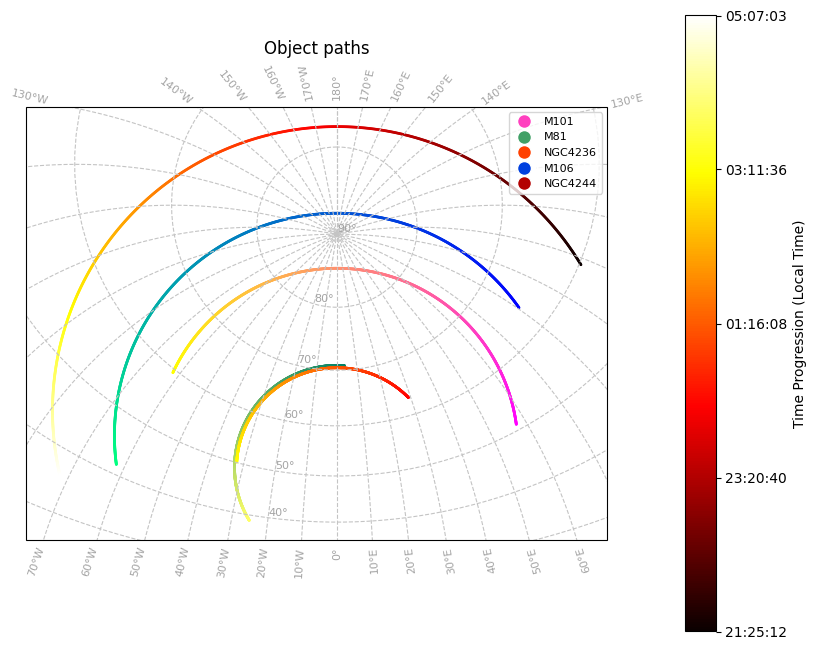

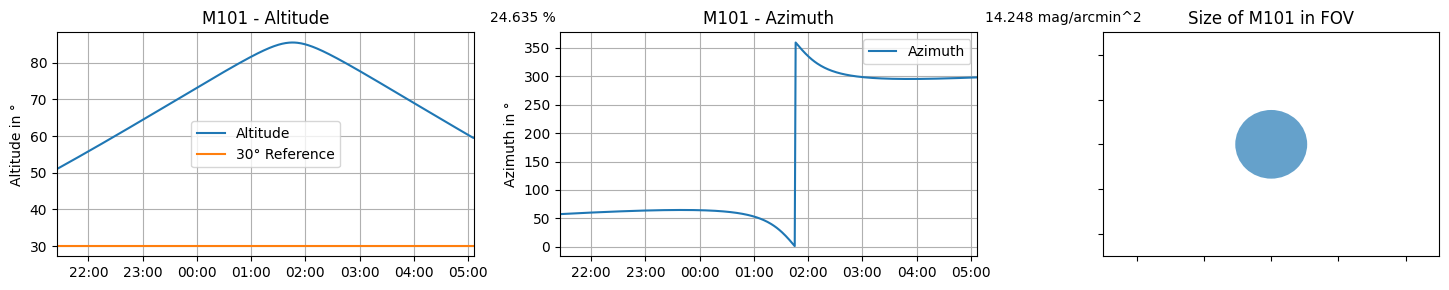

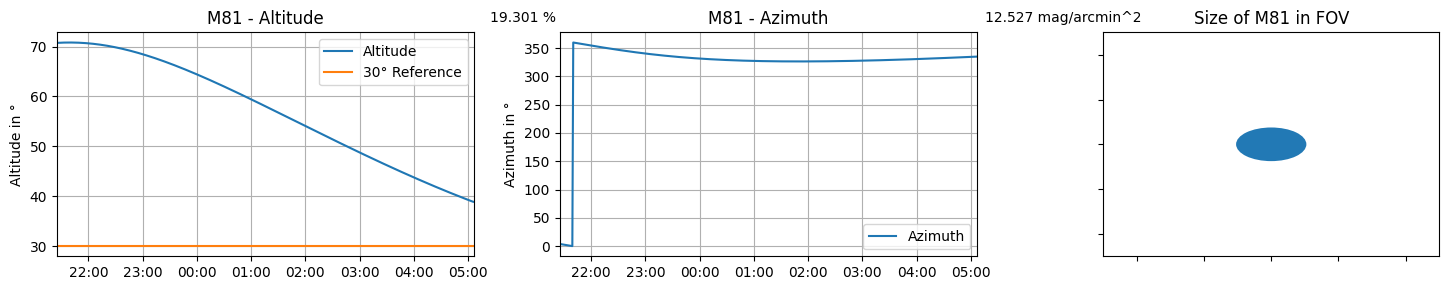

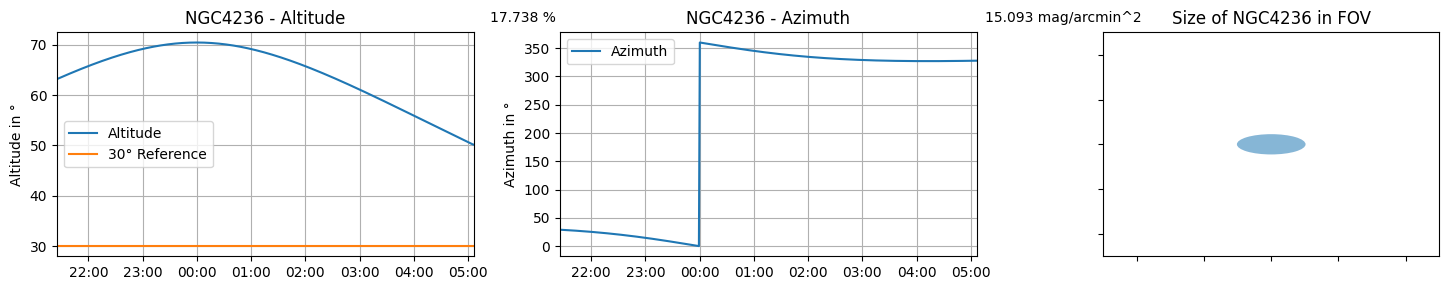

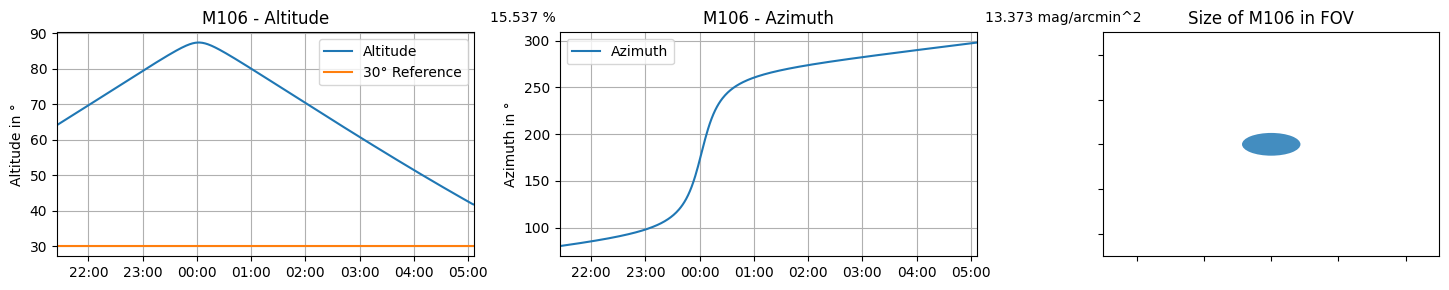

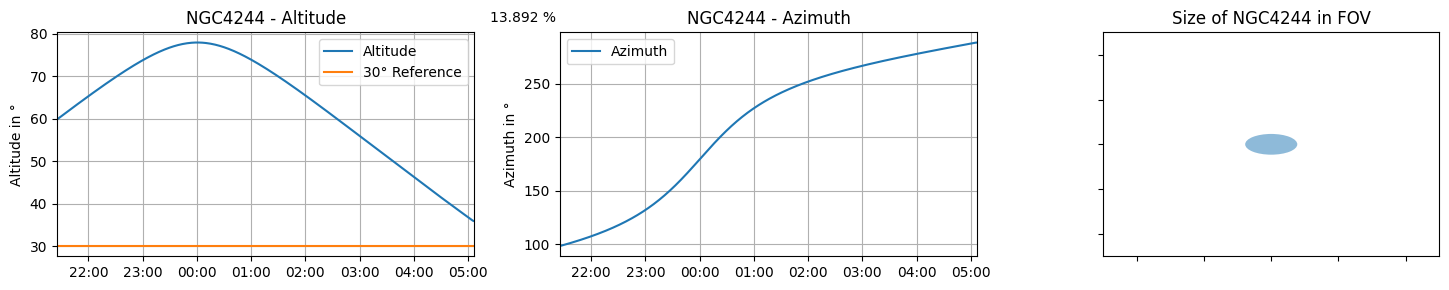

Well done, this function is now over!


In [ ]:
# Example usage

# Loading the object files
messier_arr = load_variable_column_file("Messier.txt")
NGC_arr = load_variable_column_file("NGC.txt")
IC_arr = load_variable_column_file("IC.txt")

data_arr = np.vstack((messier_arr, NGC_arr, IC_arr))

#Location data of your observation point (e.g., Dr. Remeis Observatory)
Lon = 10.88846
Lat = 49.88474
ele = 282

TelescopeData() # Function to set your telescope data. (Focal length, Pixel Size, Dimensions)

selected_date = "2024-04-15" # Example date in format "YYYY-MM-DD"
timezone = "Europe/Berlin" # Example timezone

final_best = Final_Best(data_arr, obs_date=selected_date, Lon=Lon, Lat=Lat, ele=ele, timezone=timezone, min_frac=0.08,Galaxies= 1,Nebulae=1) # Example function call to get the best objects
PlotBestObjects(objects=data_arr, obs_date=selected_date, Lon=Lon, Lat=Lat, ele=ele, timezone=timezone, min_frac=0.08, k = 5 , Galaxies = 1, Nebulae= 1) # Example function call to plot the best objects